<p style="font-weight:bold; letter-spacing: 2px; color:#F5F5DC; font-size:140%; text-align:left; max-width: 1050px; padding: 10px; border-bottom: 3px solid #D2B48C"> KNN Classification</p>

![alt text](pipeline_image.jpg "KNN_figma")

*Import Libraries*

In [174]:
# import custom classes, functions and variables. Reload file in to memory on cell excution.
import importlib
import settings
importlib.reload(settings)

# import data frameworks
import pandas as pd
import numpy as np

# import viz
import matplotlib.pyplot as plt
import seaborn as sns

# import ML
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm
from imblearn.over_sampling import SMOTENC


# import others
import os
import pickle
import warnings

# Specific warning categories to be ignored
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

*Import data from initial EDA*

In [175]:
df = pd.read_csv(os.path.join(settings.DATA_EDA_DIR, settings.DATA_EDA_FILE), sep=",")
if len(df) > 0:
    print("df loaded")

df loaded


*Split data and prepare labels*

In [176]:
ALL_FEATURES = ['Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 
                'Physical Activity Level', 'Stress Level', 'BMI Category', 'Heart Rate', 
                'Daily Steps', 'Blood Pressure Category']
X = df[ALL_FEATURES]
y = df[settings.LABEL]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Encode y vector 
map = {"None":0, "Sleep Apnea":1, "Insomnia":2}
# apply mapping function
settings.column_mapper(y_train, "Sleep Disorder", map)
settings.column_mapper(y_test, "Sleep Disorder", map)

# reshape labels to 1-D array (vector) 
y_train, y_test = y_train.values.reshape(-1), y_test.values.reshape(-1)

*Preprocess steps*

In [146]:
# Create a column transformer for ohe and scaling
column_trans = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), X_train.select_dtypes(include=['object']).columns),
        ('scale', StandardScaler(), X_train.select_dtypes(include=['float64', 'int64']).columns)
    ],
    remainder='passthrough')

transformed_X_train_array = column_trans.fit_transform(X_train)
transformed_X_test_array = column_trans.transform(X_test)

# Convert to df as a sense check. Use only for interpretibility before using for pipeline. 
transformed_X_train_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_train_array)
transformed_X_test_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_test_array)

# # Check ohe and scaled datasets
# display("train: check for dummy encoded columns and scaled values (mean 0 and std 1)",transformed_X_train_df.shape, transformed_X_train_df.describe().loc[["mean", "std"],:])
# display("test: check for same dummy encoded columns and scaled values (mean close to 0 and std close to 1)",transformed_X_test_df.shape, transformed_X_test_df.describe().loc[["mean", "std"],:])

*Create pipeline and base model*

In [170]:
# create model
model_knn = KNeighborsClassifier() # default n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski'

# create sklearn pipeline
pipeline_knn = settings.create_pipeline(["preprocess", column_trans], ["knn_classifier", model_knn])

# create cross validation object for cross_val_score
cv_knn = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

# run training cross validation on pipeline 
cv_scores = cross_val_score(pipeline_knn, X_train, y_train, scoring='accuracy', cv=cv_knn)

settings.cross_val_summary(pipeline_knn, cv_scores, X_train, y_train, X_test, y_test)

Train Accuracy: 89.700 %
Mean CV Train Accuracy: 87.5200 % ( +- 3.800 % )
Test Accuracy: 92.9200 %


Average train score across seeds: 91.200 %
Average cv train score across seeds: 88.600 %
Average test score across seeds: 89.100 %


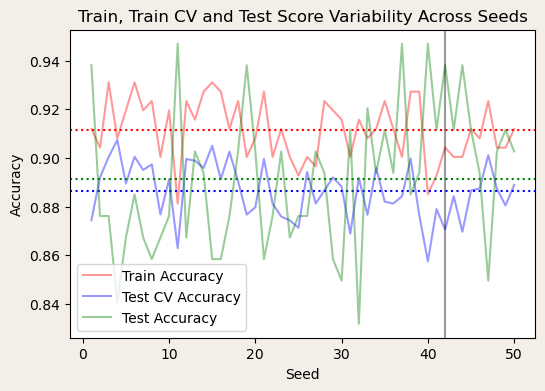

In [159]:
# large variability observed across folds. Explore impact of chosen seed.
settings.plot_seed_variability(X=X, y=y, test_size=0.3, current_seed = 42, num_seeds=50, pipeline_or_model=pipeline_knn, scoring="accuracy", cv_object=cv_knn, pipeline_type="sklearn")

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>High baseline model train cv accuracy 87.5% but much higher test accuracy 92.9% which is even above train accuracy (89.7%).</li>
    <li>High variation in cv accuracy scores: 4.3%</li>     
    <li>High dependance on data split which itself depends on the random seed: reason for higher test accuracy in the first case. As seen in the last graph, varying the random seed 50 times results in occassions where test score is much higher than the average (89.1%). On average, model shows very little sign of overfitting but large variation in test scores cast the reliability in to doubt. Train CV scores, even with their high internal variation, provide a more stable assessment.</li>
    <li>Goal will be to maximise Train CV scores and reduce variation. Test score will be evaluated as an additional step but not used for model selection. 
</ul>
</div>


In [30]:
# Save baseline pipeline to file  
settings.save_pipeline("best_knn_classification_pipeline.pkl", pipeline_knn)

*Hyperparam tuning*

*Smoothing*

In [171]:
# Define the parameter grid
param_grid_knn = {
    'knn_classifier__n_neighbors': [3, 5, 7, 9, 11, 13, 15],     # List of values for n_neighbors
    'knn_classifier__weights': ['uniform', 'distance'],  # List of values for weights
    'knn_classifier__p': [1, 2],                  # List of values for p
    'knn_classifier__metric': ['euclidean', 'manhattan']  # List of values for metric
}

# Create and fit GridSearchCV object on train data
grid_search_knn = GridSearchCV(pipeline_knn, param_grid=param_grid_knn, scoring='accuracy', cv=cv_knn, n_jobs=-1)
grid_search_knn.fit(X_train, y_train)

settings.hyperparam_tune_summary(grid_search_knn, X_train, y_train, X_test, y_test)

Best Parameters:


,knn_classifier__metric,knn_classifier__n_neighbors,knn_classifier__p,knn_classifier__weights
0,manhattan,3,1,uniform


---------------------
Using best parameters
---------------------
Train Accuracy: 90.800 %
Mean CV Train Accuracy: 89.100 % ( +- 3.300 % )
Test Accuracy: 94.700 %


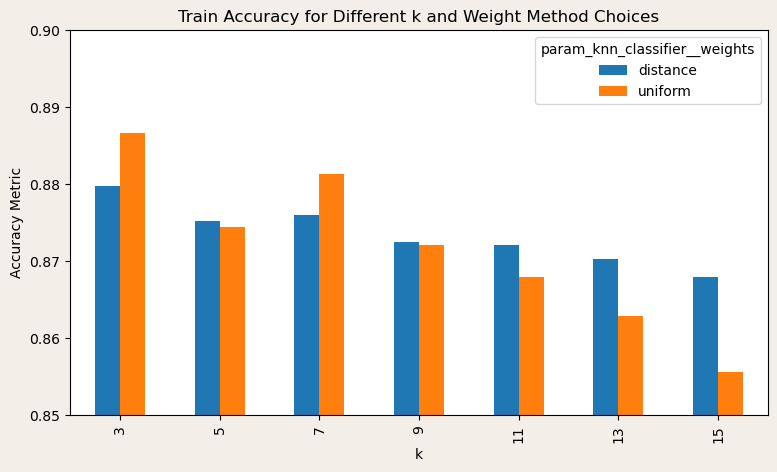

In [172]:
# Access the grid search results
results = grid_search_knn.cv_results_

# Extract k values, weights values and accuracy scores
grouped = pd.DataFrame(results)
grouped = grouped.groupby(["param_knn_classifier__n_neighbors", "param_knn_classifier__weights"])["mean_test_score"].mean().unstack()

# Plot the grouped bar chart
fig, ax = plt.subplots(figsize=(6, 4), gridspec_kw={'hspace': 0.8}, facecolor="#F3EEE7")
grouped.plot(kind='bar', figsize=(9, 5), ax=ax)

# Add plot details
ax.set_ylim(0.85, 0.9)
ax.set_xlabel('k')
ax.set_ylabel('Accuracy Metric')
ax.set_title('Train Accuracy for Different k and Weight Method Choices')
plt.show()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>model train cv accuracy improved to 88.8%</li>
    <li>Variation in train CV improved to 3.3%</li> 
</ul>
</div>


*Review metrics for hypertuned model*

Test Accuracy: 92.9200 %

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        66
           1       0.81      0.88      0.84        24
           2       0.90      0.83      0.86        23

    accuracy                           0.93       113
   macro avg       0.90      0.90      0.90       113
weighted avg       0.93      0.93      0.93       113



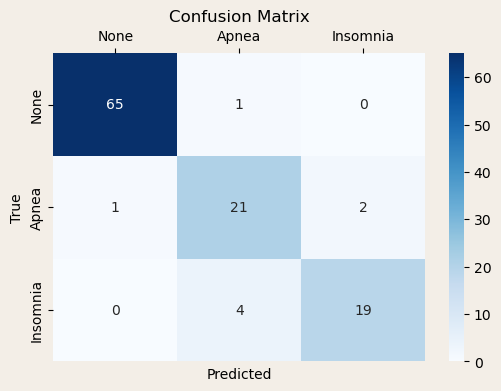

In [167]:
# Print test accuracy
pipeline_knn.fit(X_train, y_train)
print("Test Accuracy:", settings.score_formatter(pipeline_knn.score(X_test, y_test), 4))

# Generate prediction and show classification report
y_pred = pipeline_knn.predict(X_test)
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

# Generate confusion matrix
class_labels = ["None","Apnea","Insomnia"]
conf_matrix = confusion_matrix(y_test, y_pred)

settings.plot_conf_matrix(class_labels, conf_matrix)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Model best at predicting None, with a very high precision and recall (98%)</li>
    <li>Apnea has the lower recall at 88% (3 incorrect out of test 24 instances) and lowest precision at 81%</li>
    <li>Insomnia has the lowest recall at 83% (4 incorrect out of 23 instances) but higher precision at 90%</li>
</ul>
</div>


*Addressing Class Imbalance: Exploring SMOTE-NC*

In [17]:
# instantiate SMOTENC object with categorical indicies of transformed X_train dataset
categorical_features = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)

# Proving smote object works using the X array transformed by column_trans
from collections import Counter
smote_x, smote_y = smote_nc.fit_resample(transformed_X_train_df, y_train)
print(f"Original class counts: {Counter(y_train)}")
print(f"New class counts: {Counter(smote_y)}")

Original class counts: Counter({0: 153, 2: 54, 1: 54})
New class counts: Counter({2: 153, 1: 153, 0: 153})


In [20]:
# Set up pipeline using imblearn's Pipeline class (SMOTE not compatible with sklearn's Pipeline)
# Reuse model with tuned hyperparameters
steps = [('column_trans', column_trans), ('smote', smote_nc), ("knn_classifier", model_knn)]
pipeline_knn = Pipeline_imb(steps)

# Fit pipeline and produce training accuracy
pipeline_knn.fit(X_train, y_train)
train_acc = pipeline_knn.score(X_train, y_train)
print('Train Accuracy:', settings.score_formatter(train_acc, 3))

# run training cross validation on pipeline 
cv_scores = cross_val_score(pipeline_knn, X_train, y_train, scoring='accuracy', cv=cv_knn)

# Calculate mean and standard deviation of cross-validation train scores
mean_train_cv = np.mean(cv_scores)
std_train_cv = np.std(cv_scores)
print('Mean CV Train Accuracy:', settings.score_formatter(mean_train_cv, 4),
    "( +-", settings.score_formatter(std_train_cv, 3), ")")

# extract model (remove smote for test) and produce test score 
model_knn = pipeline_knn.named_steps['knn_classifier']
test_accuracy = model_knn.score(transformed_X_test_df.values, y_test)
print('Test Accuracy:', settings.score_formatter(test_accuracy, 3))


Train Accuracy: 90.800 %
Mean CV Train Accuracy: 87.1100 % ( +- 4.500 % )
Test Accuracy: 93.800 %


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98        66
           1       0.81      0.92      0.86        24
           2       0.95      0.87      0.91        23

    accuracy                           0.94       113
   macro avg       0.92      0.92      0.92       113
weighted avg       0.94      0.94      0.94       113



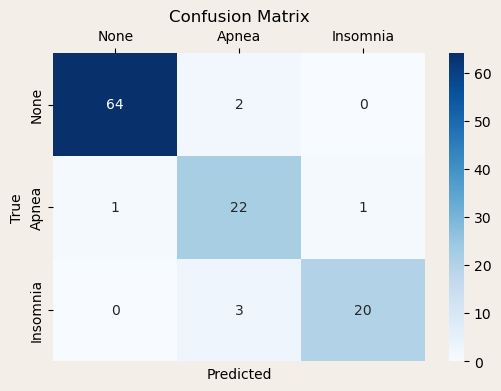

In [22]:
# Generate prediction and show classification report
y_pred = pipeline_knn.predict(X_test)
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# Generate confusion matrix
class_labels = ["None","Apnea","Insomnia"]
conf_matrix = confusion_matrix(y_test, y_pred)

settings.plot_conf_matrix(class_labels, conf_matrix)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>SMOTE shows no improvement</li>
</ul>
</div>
